# MyND Offline Processing: Data Analysis
Author: Geeling Chau<br> 
<br>
Description: Visualize power bin features<br>
Sources: 
- Ollie's Segment Speller Offline Processing Code https://github.com/ollie-d/SegSpeller/blob/master/Offline%20Processing.ipynb 
- neurodsp https://github.com/neurodsp-tools/neurodsp
- FOOOF https://fooof-tools.github.io/fooof/index.html 
- PyEEG http://pyeeg.sourceforge.net/ 


## Imports

In [1]:
from helperFunctions import *
from constants import *
from dataAnalysisFunctions import *

from neurodsp.plts.spectral import *

import seaborn as sns; sns.set()

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Create a binning interval
binning=[4, 8, 12, 30]
intervals = getIntervals(binning)

In [4]:
def getPowerRatioAvgSEM(eeg_list, num_eeg_timepoints=499, binning=binning): 
    power_ratio = [getPowerRatio(data[:num_eeg_timepoints], binning) for data in eeg_list]
    return np.mean(power_ratio, axis=0), getSEM(power_ratio)

## Data imports

In [98]:
filename_foldername_dict_path = "../data/most_currently_updated.pickle"
filename_foldername_dict = loadPickle(filename_foldername_dict_path)

foldername='P006'#filename_foldername_dict["foldername"]
filename='part_P006_exp001_block_long'#filename_foldername_dict["filename"]
print(foldername, filename)

dataframe_directory = "../data/dataframe/"+foldername+"/"
dataframe_path = dataframe_directory+filename+".pickle"

unfocused_states_df_directory = "../data/unfocused_states_df/"+foldername+"/"
unfocused_states_df_path = unfocused_states_df_directory+filename+".pickle"

df = loadPickle(dataframe_path)

P006 part_P006_exp001_block_long


In [6]:
article_results_directory = "../data/article_results/"+foldername+"/"
article_results_path = article_results_directory+filename+".pickle"

article_results_sem_directory = "../data/article_sem_results/"+foldername+"/"
article_results_sem_path = article_results_sem_directory+filename+".pickle"


In [7]:
incorporate_matlab_data = False
if incorporate_matlab_data: 
    filtered_matlab_data_directory = "../data/filtered_matlab_data/"+foldername+"/"
    filtered_matlab_data_path = filtered_matlab_data_directory+filename+".pickle"
    filtered_matlab_data = loadPickle(filtered_matlab_data_path)
    all_data = filtered_matlab_data
else :
    filtered_cleaned_data_directory = "../data/filtered_cleaned_data/"+foldername+"/"
    filtered_cleaned_data_path = filtered_cleaned_data_directory+filename+".pickle"
    filtered_cleaned_data = loadPickle(filtered_cleaned_data_path)
    all_data = filtered_cleaned_data

In [8]:
def getTimeBalanced(df1, df2, window_size=10) :
    start_1 = df1.iloc[0]["data_index"]
    start_2 = df2.iloc[0]["data_index"]
    # Find minimum of the two starting indexes
    min_ind = start_1 if start_1 < start_2 else start_2
    max_ind = min_ind + window_size
    
    df1_to_return_indexes = list()
    df2_to_return_indexes = list()
    
    df1_copy = df1.copy()
    df2_copy = df2.copy()
    max_data_index = max(df1["data_index"]) if max(df1["data_index"]) > max(df2["data_index"]) else max(df2["data_index"])
    # print(max_data_index)
    while min_ind < max_data_index : 
        # get sublists
        sub_df1 = df1_copy[(df1_copy["data_index"] >= min_ind) & (df1_copy["data_index"] < max_ind)]
        sub_df2 = df2_copy[(df2_copy["data_index"] >= min_ind) & (df2_copy["data_index"] < max_ind)]

        # if any of the sub lists are empty, increment min index
        if (len(sub_df1) == 0) or (len(sub_df2) == 0): 
            min_ind += 1
        else :
            # Otherwise, continue poping from both lists until one is empty, by which you increase min_index to after the numbers just added
            df1_to_add = sub_df1.iloc[0]["data_index"]
            df2_to_add = sub_df2.iloc[0]["data_index"]
            while not((len(sub_df1) == 0) or (len(sub_df2) == 0)): 
                df1_to_add = sub_df1.iloc[0]["data_index"]
                df2_to_add = sub_df2.iloc[0]["data_index"]

                df1_to_return_indexes.append(df1_to_add)
                df2_to_return_indexes.append(df2_to_add)

                sub_df1 = sub_df1[sub_df1["data_index"] != df1_to_add]
                sub_df2 = sub_df2[sub_df2["data_index"] != df2_to_add]
                df1_copy = df1_copy[df1_copy["data_index"] != df1_to_add]
                df2_copy = df2_copy[df2_copy["data_index"] != df2_to_add]

            min_ind += 1

        max_ind = min_ind + window_size
    # print(df1_to_return_indexes)
    return df1[df1["data_index"].isin(df1_to_return_indexes)], df2[df2["data_index"].isin(df2_to_return_indexes)]



In [9]:
# Get sections
numSections = getNumSections(filtered_cleaned_data)

data_type= "data_matlab" if incorporate_matlab_data else "data"


In [10]:
# Get the focus vs unfocus of alpha vs theta vs beta
if not os.path.isfile(article_results_path):

    article_results = {}
    article_sem_results = {}
    unfocused_states = {}
    unfocused_states["timepoint"] = list()
    unfocused_states["article_num_before_after"] = list()
    unfocused_states["unfocused_times"] = list()

    

    for article in range(1, numSections+1):
        df_article = df[df["section_number"] == article]

        article_results[article] = {}
        article_results[article]["focus"] = {}
        article_results[article]["focus"]["alpha"] = list()
        article_results[article]["focus"]["theta"] = list()
        article_results[article]["focus"]["beta"] = list()

        article_results[article]["unfocus"] = {}
        article_results[article]["unfocus"]["alpha"] = list()
        article_results[article]["unfocus"]["theta"] = list()
        article_results[article]["unfocus"]["beta"] = list()


        article_sem_results[article] = {}
        article_sem_results[article]["focus"] = {}
        article_sem_results[article]["focus"]["alpha"] = list()
        article_sem_results[article]["focus"]["theta"] = list()
        article_sem_results[article]["focus"]["beta"] = list()

        article_sem_results[article]["unfocus"] = {}
        article_sem_results[article]["unfocus"]["alpha"] = list()
        article_sem_results[article]["unfocus"]["theta"] = list()
        article_sem_results[article]["unfocus"]["beta"] = list()
        
        


        for num_before in range(10):

            article_results[article]["focus"]["alpha"].append(list())
            article_results[article]["focus"]["theta"].append(list())
            article_results[article]["focus"]["beta"].append(list())

            article_results[article]["unfocus"]["alpha"].append(list())
            article_results[article]["unfocus"]["theta"].append(list())
            article_results[article]["unfocus"]["beta"].append(list())

            article_sem_results[article]["focus"]["alpha"].append(list())
            article_sem_results[article]["focus"]["theta"].append(list())
            article_sem_results[article]["focus"]["beta"].append(list())

            article_sem_results[article]["unfocus"]["alpha"].append(list())
            article_sem_results[article]["unfocus"]["theta"].append(list())
            article_sem_results[article]["unfocus"]["beta"].append(list())


            print(num_before)

            for num_after in range(10): 

                unfocused_state = getSmoothedPerformance(list((df_article["is_pressed"] == False) & (df_article["is_target"] == True)), num_before, num_after)
                for i, state in enumerate(unfocused_state):
                    unfocused_states["timepoint"].append(i)
                    unfocused_states["article_num_before_after"].append((article, num_before, num_after))
                    unfocused_states["unfocused_times"].append(state)


                #print(unfocused_state)
                unfocused_df = df_article[unfocused_state]
                focused_df = df_article[np.logical_not(unfocused_state)]

                if(len(unfocused_df) == 0 or len(focused_df) == 0) :
                    article_results[article]["focus"]["alpha"][num_before].append(0)
                    article_results[article]["focus"]["theta"][num_before].append(0)
                    article_results[article]["focus"]["beta"][num_before].append(0)

                    article_results[article]["unfocus"]["alpha"][num_before].append(0)
                    article_results[article]["unfocus"]["theta"][num_before].append(0)
                    article_results[article]["unfocus"]["beta"][num_before].append(0)

                    article_sem_results[article]["focus"]["alpha"][num_before].append(0)
                    article_sem_results[article]["focus"]["theta"][num_before].append(0)
                    article_sem_results[article]["focus"]["beta"][num_before].append(0)

                    article_sem_results[article]["unfocus"]["alpha"][num_before].append(0)
                    article_sem_results[article]["unfocus"]["theta"][num_before].append(0)
                    article_sem_results[article]["unfocus"]["beta"][num_before].append(0)
                else : 
                    f_df, u_df = getTimeBalanced(focused_df, unfocused_df, window_size=max(2, (num_before + num_after + 5)))

#                     if(num_before == 3 and num_after == 8) :
#                         plt.figure(figsize=(20,10))
#                         plt.scatter(focused_df["data_index"].values, [1]*len(focused_df["data_index"].values))
#                         plt.scatter(unfocused_df["data_index"].values, [1]*len(unfocused_df["data_index"].values))

#                         plt.scatter(f_df["data_index"].values, [0]*len(f_df["data_index"].values))
#                         plt.scatter(u_df["data_index"].values, [0]*len(u_df["data_index"].values))

#                         plt.show()

                    focused_power_ratio_avg, SEM_focused_power_ratio = getPowerRatioAvgSEM(getEEGFromDataFrame_AvgLeftRight(f_df, data_type=data_type))
                    unfocused_power_ratio_avg, SEM_unfocused_power_ratio = getPowerRatioAvgSEM(getEEGFromDataFrame_AvgLeftRight(u_df, data_type=data_type))


                    article_results[article]["focus"]["alpha"][num_before].append(focused_power_ratio_avg[2])
                    article_results[article]["focus"]["theta"][num_before].append(focused_power_ratio_avg[0])
                    article_results[article]["focus"]["beta"][num_before].append(focused_power_ratio_avg[1])

                    article_results[article]["unfocus"]["alpha"][num_before].append(unfocused_power_ratio_avg[2])
                    article_results[article]["unfocus"]["theta"][num_before].append(unfocused_power_ratio_avg[0])
                    article_results[article]["unfocus"]["beta"][num_before].append(unfocused_power_ratio_avg[1])

                    article_sem_results[article]["focus"]["alpha"][num_before].append(SEM_focused_power_ratio[2])
                    article_sem_results[article]["focus"]["theta"][num_before].append(SEM_focused_power_ratio[0])
                    article_sem_results[article]["focus"]["beta"][num_before].append(SEM_focused_power_ratio[1])

                    article_sem_results[article]["unfocus"]["alpha"][num_before].append(SEM_unfocused_power_ratio[2])
                    article_sem_results[article]["unfocus"]["theta"][num_before].append(SEM_unfocused_power_ratio[0])
                    article_sem_results[article]["unfocus"]["beta"][num_before].append(SEM_unfocused_power_ratio[1])

    # Visualize the different cases we're considering
    unfocused_states_df = pd.DataFrame(unfocused_states)
                   
else :
    article_results = loadPickle(article_results_path)
    article_sem_results = loadPickle(article_results_sem_path)
    unfocused_states_df = loadPickle(unfocused_states_sem_path)

In [ ]:
pivoted = unfocused_states_df.pivot("article_num_before_after", "timepoint", "unfocused_times")
pivoted = pivoted.fillna(False)

plt.figure(figsize=(20,10))
plt.title("Unfocused States (white)")
ax = sns.heatmap(pivoted, cbar=False)  

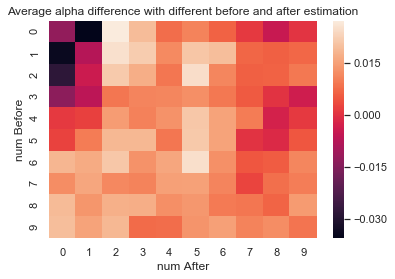

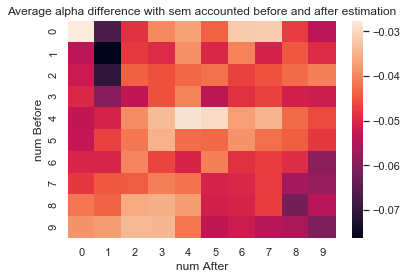

In [11]:
# Alpha heatmaps of differences to see what is best to use
average_alpha_diff_list = []
average_alpha_SEM_accounted_diff_list = []
for i in range(1, numSections+1):
    if len(article_results[i]["focus"]["alpha"][0])>0:
        result = np.array(article_results[i]["focus"]["alpha"]) - np.array(article_results[i]["unfocus"]["alpha"])
        average_alpha_diff_list.append(result)
        
        result_sem = np.array(article_sem_results[i]["focus"]["alpha"]) + np.array(article_sem_results[i]["unfocus"]["alpha"])
        average_alpha_SEM_accounted_diff_list.append(np.abs(result) - result_sem)
        
# Average them to see which would actually be best
result = np.mean(average_alpha_diff_list, axis=0)
ax = sns.heatmap(result)
plt.title("Average alpha difference with different before and after estimation")
plt.xlabel("num After")
plt.ylabel("num Before")
plt.show()

# Average them to see which would actually be best
result = np.mean(average_alpha_SEM_accounted_diff_list, axis=0)
ax = sns.heatmap(result)
plt.title("Average alpha difference with sem accounted before and after estimation")
plt.xlabel("num After")
plt.ylabel("num Before")
plt.show()

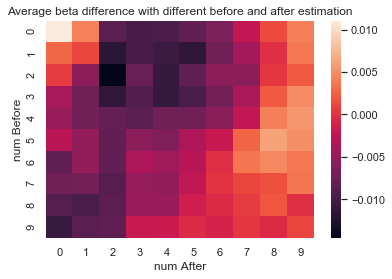

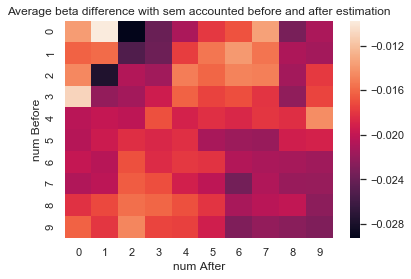

In [12]:
# Beta heatmaps of differences to see what is best to use
average_beta_diff_list = []
average_beta_SEM_accounted_diff_list = []
for i in range(1, numSections+1):
    if len(article_results[i]["focus"]["beta"][0])>0:
        result = np.array(article_results[i]["focus"]["beta"]) - np.array(article_results[i]["unfocus"]["beta"])
        average_beta_diff_list.append(result)
        
        result_sem = np.array(article_sem_results[i]["focus"]["beta"]) + np.array(article_sem_results[i]["unfocus"]["beta"])
        average_beta_SEM_accounted_diff_list.append(np.abs(result) - result_sem)

# Average them to see which would actually be best
result = np.mean(average_beta_diff_list, axis=0)
ax = sns.heatmap(result)
plt.title("Average beta difference with different before and after estimation")
plt.xlabel("num After")
plt.ylabel("num Before")
plt.show()


# Average them to see which would actually be best
result = np.mean(average_beta_SEM_accounted_diff_list, axis=0)
ax = sns.heatmap(result)
plt.title("Average beta difference with sem accounted before and after estimation")
plt.xlabel("num After")
plt.ylabel("num Before")
plt.show()



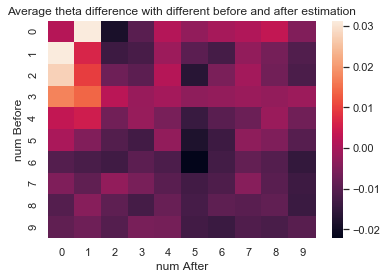

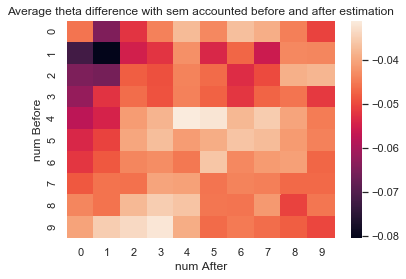

In [15]:
# Theta heatmaps of differences to see what is best to use
average_theta_diff_list = []
average_theta_SEM_accounted_diff_list = []
for i in range(1, numSections+1):
    if len(article_results[i]["focus"]["theta"][0])>0:
        result = np.array(article_results[i]["focus"]["theta"]) - np.array(article_results[i]["unfocus"]["theta"])
        average_theta_diff_list.append(result)
    
        result_sem = np.array(article_sem_results[i]["focus"]["theta"]) + np.array(article_sem_results[i]["unfocus"]["theta"])
        average_theta_SEM_accounted_diff_list.append(np.abs(result) - result_sem)

# Average them to see which would actually be best
result = np.mean(average_theta_diff_list, axis=0)
ax = sns.heatmap(result)
plt.title("Average theta difference with different before and after estimation")
plt.xlabel("num After")
plt.ylabel("num Before")
plt.show()


# Average them to see which would actually be best
result = np.mean(average_theta_SEM_accounted_diff_list, axis=0)
ax = sns.heatmap(result)
plt.title("Average theta difference with sem accounted before and after estimation")
plt.xlabel("num After")
plt.ylabel("num Before")
plt.show()


In [16]:
import warnings
warnings.filterwarnings('ignore')

In [87]:
optimal_num_before = 2
optimal_num_after = 3
df_article=df
unfocused_state = getSmoothedPerformance(list((df_article["is_pressed"] == False) & (df_article["is_target"] == True)), optimal_num_before, optimal_num_after)
unfocused_df = df_article[unfocused_state]
focused_df = df_article[np.logical_not(unfocused_state)]

f_df, u_df = getTimeBalanced(focused_df, unfocused_df, window_size=max(2, (optimal_num_before + optimal_num_after + 5)))


In [88]:
fine_binning = np.arange(1, 30, 1)

In [89]:
fine_binning

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [90]:
my_binning = np.arange(1, 30, 3)

In [91]:
my_binning

array([ 1,  4,  7, 10, 13, 16, 19, 22, 25, 28])

In [92]:
binning

[4, 8, 12, 30]

In [93]:
f_power_ratios = list()
for eeg_data in getEEGFromDataFrame_AvgLeftRight(f_df, data_type=data_type):
    f_power_ratios.append(getPowerRatio(eeg_data, binning))
u_power_ratios = list()
for eeg_data in getEEGFromDataFrame_AvgLeftRight(u_df, data_type=data_type):
    u_power_ratios.append(getPowerRatio(eeg_data, binning))
    
f_power_ratios = np.array(f_power_ratios)
u_power_ratios = np.array(u_power_ratios)


In [94]:
focus_theta_power_ratios = f_power_ratios[:, 0]
unfocus_theta_power_ratios = u_power_ratios[:, 0]



In [97]:
sp.stats.mannwhitneyu(focus_theta_power_ratios, unfocus_theta_power_ratios )

MannwhitneyuResult(statistic=2483.0, pvalue=0.4400030737113274)

In [73]:
min(focus_theta_power_ratios)

0.07926760779206223

In [74]:
max((focus_theta_power_ratios))

0.3838893858463085

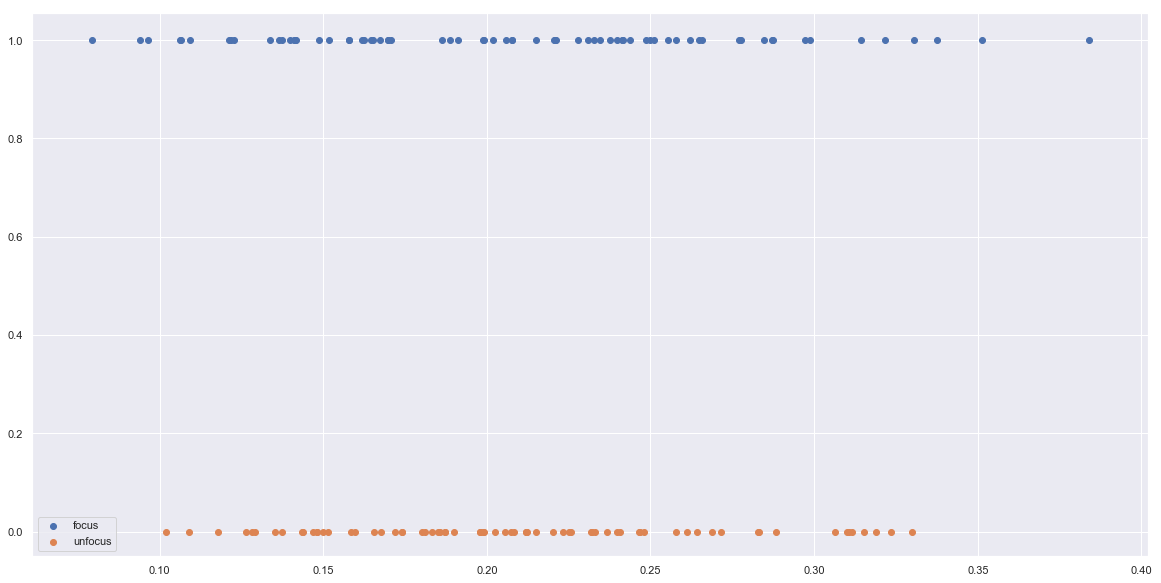

In [84]:
plt.figure(figsize=(20,10))
plt.scatter(focus_theta_power_ratios, [1] * len(focus_theta_power_ratios), label="focus")
plt.scatter(unfocus_theta_power_ratios, [0] * len(unfocus_theta_power_ratios), label="unfocus")
plt.legend()
plt.show()

In [ ]:
mannwhitneyu

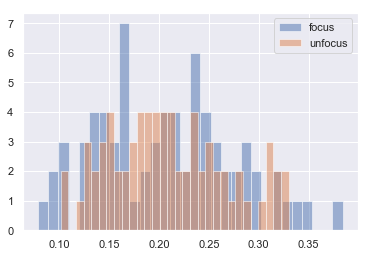

In [83]:
plt.hist(focus_theta_power_ratios, bins=30, alpha=0.5, label="focus")
plt.hist(unfocus_theta_power_ratios, bins=30, alpha=0.5, label="unfocus")
plt.legend()
plt.show()

In [54]:
X = np.append(f_power_ratios, u_power_ratios, axis=0)
y = np.append(np.array([1] * len(f_power_ratios)), np.array([0] * len(u_power_ratios)))

len(X)

170

In [55]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [56]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [57]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA()
fit = lda.fit(X_train, y_train)
y_predict = lda.predict(X_test)
lda.score(X_test, y_test)

0.5588235294117647

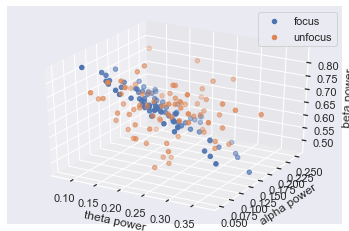

In [26]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(np.array(f_power_ratios)[:, 0], np.array(f_power_ratios)[:, 1], np.array(f_power_ratios)[:, 2], label="focus")
ax.scatter(np.array(u_power_ratios)[:, 0], np.array(u_power_ratios)[:, 1], np.array(f_power_ratios)[:, 2], label="unfocus")
plt.legend()
ax.set_xlabel("theta power")
ax.set_ylabel("alpha power")
ax.set_zlabel("beta power")
plt.show()


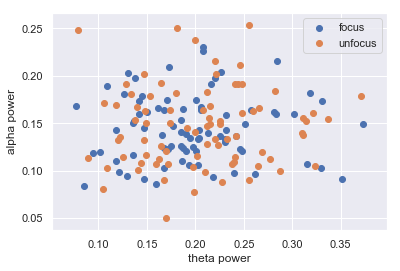

In [27]:
plt.scatter(np.array(f_power_ratios)[:, 0], np.array(f_power_ratios)[:, 1], label="focus")
plt.scatter(np.array(u_power_ratios)[:, 0], np.array(u_power_ratios)[:, 1], label="unfocus")
plt.legend()
plt.xlabel("theta power")
plt.ylabel("alpha power")
plt.show()


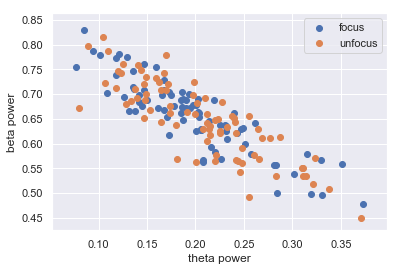

In [28]:
plt.scatter(np.array(f_power_ratios)[:, 0], np.array(f_power_ratios)[:, 2], label="focus")
plt.scatter(np.array(u_power_ratios)[:, 0], np.array(u_power_ratios)[:, 2], label="unfocus")
plt.legend()
plt.xlabel("theta power")
plt.ylabel("beta power")
plt.show()


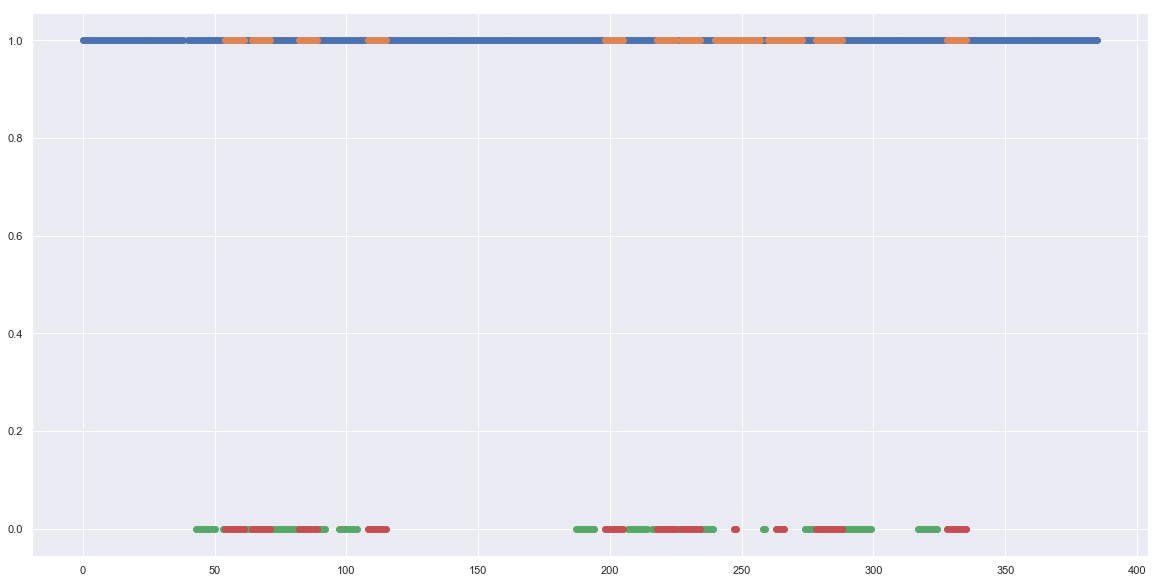

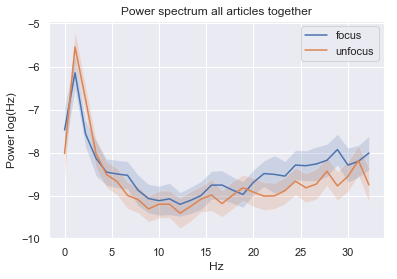

num focus 81 num unfocus 81


In [29]:
# Closer look at the optimal focus model

plt.figure(figsize=(20,10))
plt.scatter(focused_df["data_index"].values, [1]*len(focused_df["data_index"].values))
plt.scatter(unfocused_df["data_index"].values, [1]*len(unfocused_df["data_index"].values))

plt.scatter(f_df["data_index"].values, [0]*len(f_df["data_index"].values))
plt.scatter(u_df["data_index"].values, [0]*len(u_df["data_index"].values))

plt.show()

focused_df=f_df.copy()
unfocused_df=u_df.copy()


focused_power_ratio_avg, SEM_focused_power_ratio = getPowerRatioAvgSEM(getEEGFromDataFrame_AvgLeftRight(focused_df, data_type=data_type))
unfocused_power_ratio_avg, SEM_unfocused_power_ratio = getPowerRatioAvgSEM(getEEGFromDataFrame_AvgLeftRight(unfocused_df, data_type=data_type))


focused_freqs, focused_psds, focused_psd_avg = getFreqsAndPSD(tidyEEGList(getEEGFromDataFrame_AvgLeftRight(focused_df, data_type=data_type))) 
focused_psd_sem = getSEM(np.log(focused_psds))

unfocused_freqs, unfocused_psds, unfocused_psd_avg = getFreqsAndPSD(tidyEEGList(getEEGFromDataFrame_AvgLeftRight(unfocused_df, data_type=data_type)))
unfocused_psd_sem = getSEM(np.log(unfocused_psds))


plot_window_size = 30


freq1 = focused_freqs[:plot_window_size]
psd1 = np.log(focused_psd_avg[:plot_window_size])
sem1 = focused_psd_sem[:plot_window_size]

plt.plot(freq1, psd1, label="focus")
plt.fill_between(freq1, psd1-sem1, psd1+sem1, alpha = 0.2)

freq2 = unfocused_freqs[:plot_window_size]
psd2 = np.log(unfocused_psd_avg[:plot_window_size])
sem2 = unfocused_psd_sem[:plot_window_size]

plt.plot(freq2, psd2, label="unfocus")
plt.fill_between(freq2, psd2-sem2, psd2+sem2, alpha = 0.2)

plt.legend()
plt.title("Power spectrum all articles together")
plt.xlabel("Hz")
plt.ylabel("Power log(Hz)")
plt.show()

print("num focus", len(focused_df), "num unfocus", len(unfocused_df))

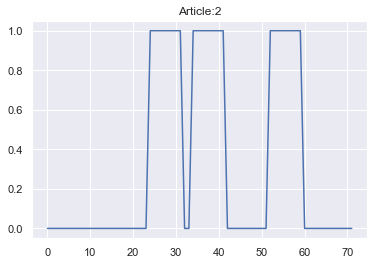

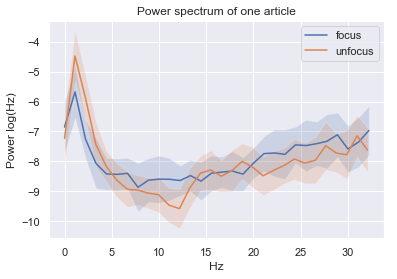

num focus 24 num unfocus 24


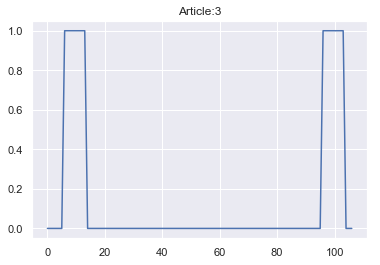

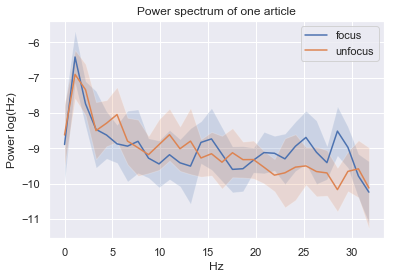

num focus 16 num unfocus 16


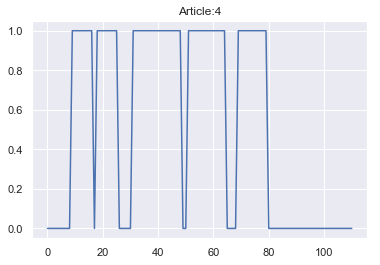

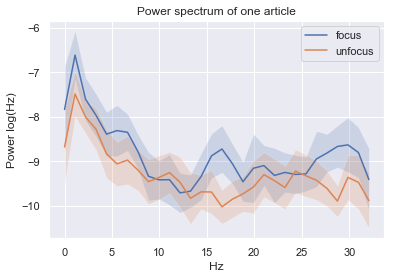

num focus 32 num unfocus 32


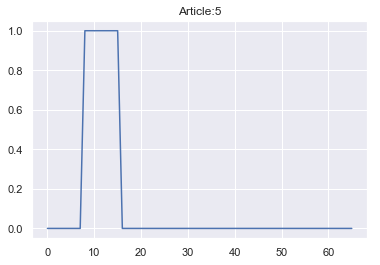

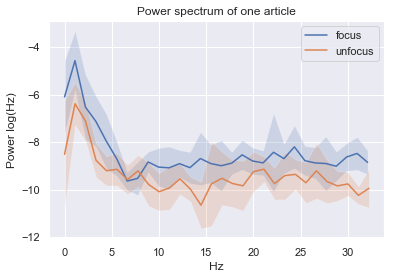

num focus 8 num unfocus 8


In [30]:
# Closer look at the optimal focus model

focus_eeg_list = list()
unfocus_eeg_list = list()

for i in range(1, numSections + 1): 
    df_article=df[df["section_number"] == i]
    unfocused_state = getSmoothedPerformance(list((df_article["is_pressed"] == False) & (df_article["is_target"] == True)), optimal_num_before, optimal_num_after)
    unfocused_df = df_article[unfocused_state]
    focused_df = df_article[np.logical_not(unfocused_state)]
    
    if (len(focused_df)==0 or len(unfocused_df)==0):
        continue
    
    
    focused_df, unfocused_df = getTimeBalanced(focused_df, unfocused_df, window_size=max(2, (optimal_num_before + optimal_num_after + 5)))

    focus_eeg_list.extend(getEEGFromDataFrame_AvgLeftRight(focused_df, data_type=data_type))
    unfocus_eeg_list.extend(getEEGFromDataFrame_AvgLeftRight(unfocused_df, data_type=data_type))
    
    plt.plot(unfocused_state)
    plt.title("Article:" + str(i))
    plt.show()
    
    
    focused_freqs, focused_psds, focused_psd_avg = getFreqsAndPSD(tidyEEGList(getEEGFromDataFrame_AvgLeftRight(focused_df, data_type=data_type))) 
    focused_psd_sem = getSEM(np.log(focused_psds))

    unfocused_freqs, unfocused_psds, unfocused_psd_avg = getFreqsAndPSD(tidyEEGList(getEEGFromDataFrame_AvgLeftRight(unfocused_df, data_type=data_type)))
    unfocused_psd_sem = getSEM(np.log(unfocused_psds))


    plot_window_size = 30


    freq1 = focused_freqs[:plot_window_size]
    psd1 = np.log(focused_psd_avg[:plot_window_size])
    sem1 = focused_psd_sem[:plot_window_size]

    plt.plot(freq1, psd1, label="focus")
    plt.fill_between(freq1, psd1-sem1, psd1+sem1, alpha = 0.2)

    freq2 = unfocused_freqs[:plot_window_size]
    psd2 = np.log(unfocused_psd_avg[:plot_window_size])
    sem2 = unfocused_psd_sem[:plot_window_size]

    plt.plot(freq2, psd2, label="unfocus")
    plt.fill_between(freq2, psd2-sem2, psd2+sem2, alpha = 0.2)

    plt.legend()
    plt.title("Power spectrum of one article")
    plt.xlabel("Hz")
    plt.ylabel("Power log(Hz)")
    plt.show()

    print("num focus", len(focused_df), "num unfocus", len(unfocused_df))


In [31]:
focused_power_ratio_avg, SEM_focused_power_ratio = getPowerRatioAvgSEM(focus_eeg_list)
unfocused_power_ratio_avg, SEM_unfocused_power_ratio = getPowerRatioAvgSEM(unfocus_eeg_list)

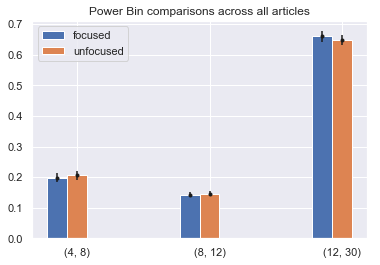

In [32]:
plt.title("Power Bin comparisons across all articles")

plotMultipleBarGraphs([focused_power_ratio_avg, unfocused_power_ratio_avg], 0.15, ["focused","unfocused"], intervals, error_values=[SEM_focused_power_ratio, SEM_unfocused_power_ratio])



In [33]:

# Write article data to files
ensureDirExists(article_results_directory)
writeToPickle(article_results, article_results_path)


ensureDirExists(article_results_sem_directory)
writeToPickle(article_sem_results, article_results_sem_path)

ensureDirExists(unfocused_states_df_directory)
writeToPickle(unfocused_states_df_results, unfocused_states_df_path)


print("Done!")
print(foldername, filename)


Done!
P006 part_P006_exp001_block_long
